## Introduction 
Autoencoder are special type of deep learning architecture that consist of two networks encoder and decoder.
The encoder, through a series of CNN and downsampling, learns a reduced dimensional representation of the input data while decoder  through the use of CNN and upsampling, attempts to regenerate the data from the these representations. A well-trained decoder is able to regenerated data that is identical or as close as possible to the original input data.
Autoencoder are generally used for anamoly detection, denoising image, colorizing the images. Here, i am going to colorize the landscape images using autoencoder.

<img src = 'https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' >

## Image Colorization
Image colorization using different softwares  has made this tarequire large amount of human effort, time and skill.But special type of deep learning architecture called autoencodersk quiet easy. Automatic image colorization often involves the use of a class of convolutional neural networks (CNN) called auhese toencoders. Tneural networks are able to distill the salient features of an image, and then regenerate the image based on these learned features. 

## Import  libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras import layers
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

### Getting landscape image data,resizing them and appending in array
To get the image in sorted order i have defined the function sorted_alphanumeric. Here, I have used open cv library to read and resize images. Finally images are normalized and are converted to array and are appended in empty list

In [2]:
os.listdir('Data/')

['landscape_Images']

In [3]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# defining the size of the image
SIZE = 160
color_img = []
path = 'Data/landscape_Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = 'Data/landscape_Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))
         
   

 84%|████████████████████████████████████████████████████████████████▊            | 6000/7129 [00:08<00:01, 702.00it/s]


### Data Visualization

In [4]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

**Plotting image pair**

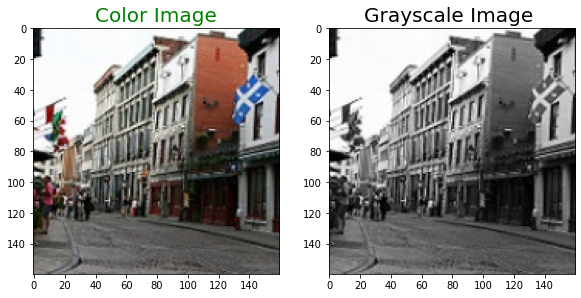

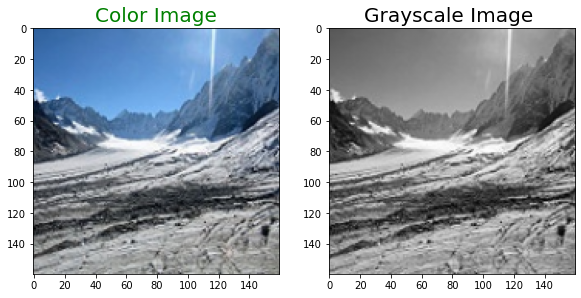

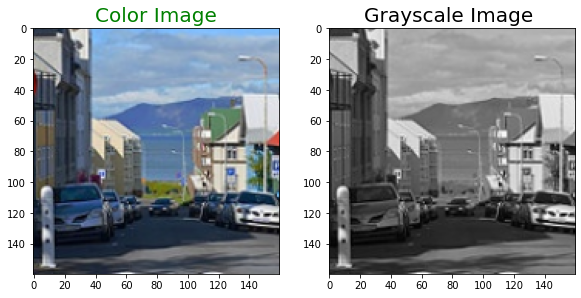

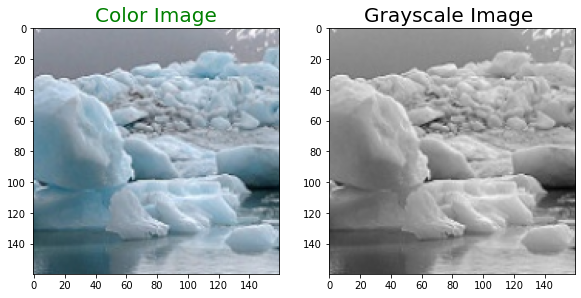

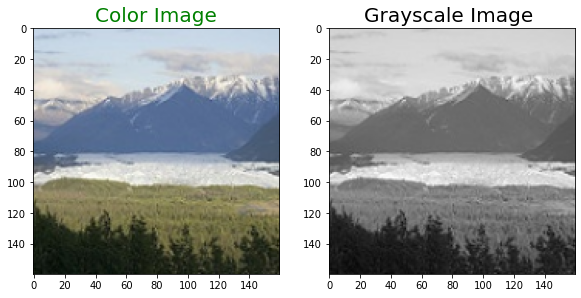

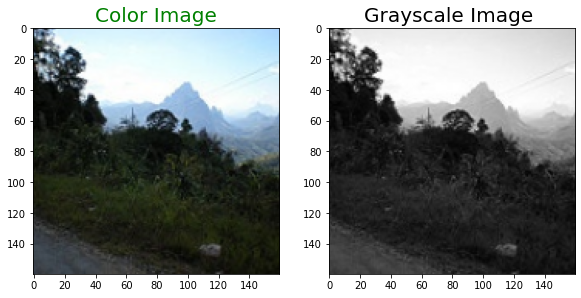

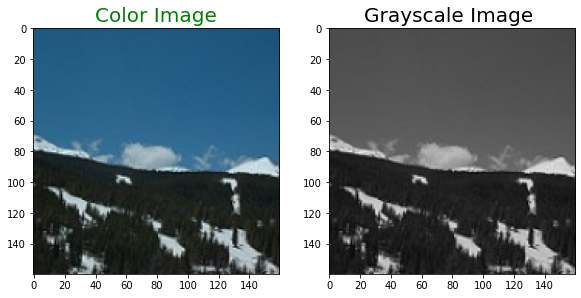

In [5]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [6]:
print(f"Number of Colour Images : {len(color_img)}\nNumber of GrayScale Images : {len(gray_img)}")

Number of Colour Images : 6000
Number of GrayScale Images : 6000


## Data preprocessing

Out of 5000 images I have sliced them to two part. train images consist 4000 images  while test images contains 1000 images.
After slicing the image array, I reshaped them so that images can be fed directly into our encoder network

In [7]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


## Model Building 

Encoder layer of our model consist blocks of Convolution layer with different number of kernel and kernel_size. Here, Convolution is used for downsampling.

Similary, Decoder layer of our model consist of  transpose convolution layer with different kernel size. Here, Decoder layer upsample image downsampled by encoder.

Since there is feature loss between the encoder and decoder layers so inorder to prevent feature loss i have concatenate corresponding encoder and decoder layers.

In [8]:
from keras import layers
def Encode(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def Decode(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


In [9]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = Encode(128,(3,3),False)(inputs)
    d2 = Encode(128,(3,3),False)(d1)
    d3 = Encode(256,(3,3),True)(d2)
    d4 = Encode(512,(3,3),True)(d3)
    
    d5 = Encode(512,(3,3),True)(d4)

    u1 = Decode(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = Decode(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = Decode(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = Decode(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = Decode(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    
    return tf.keras.Model(inputs=inputs, outputs=output)

In [10]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

### Fitting our model

In [11]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 50,batch_size = 50,verbose = 1)

Epoch 1/50
110/110 [==============================] - 433s 4s/step - loss: 0.0949 - acc: 0.3781
Epoch 2/50
110/110 [==============================] - 476s 4s/step - loss: 0.0635 - acc: 0.4364
Epoch 3/50
110/110 [==============================] - 440s 4s/step - loss: 0.0565 - acc: 0.4599
Epoch 4/50
110/110 [==============================] - 484s 4s/step - loss: 0.0532 - acc: 0.4720
Epoch 5/50
110/110 [==============================] - 457s 4s/step - loss: 0.0503 - acc: 0.4877
Epoch 6/50
110/110 [==============================] - 536s 5s/step - loss: 0.0491 - acc: 0.4965
Epoch 7/50
110/110 [==============================] - 487s 4s/step - loss: 0.0481 - acc: 0.5046
Epoch 8/50
110/110 [==============================] - 520s 5s/step - loss: 0.0473 - acc: 0.5179
Epoch 9/50
110/110 [==============================] - 573s 5s/step - loss: 0.0466 - acc: 0.5205
Epoch 10/50
110/110 [==============================] - 484s 4s/step - loss: 0.0456 - acc: 0.5362
Epoch 11/50
110/110 [==================

In [12]:
model.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 14s 844ms/step - loss: 0.0476 - acc: 0.5588


[0.04760761186480522, 0.5588223934173584]

In [13]:
model.save('Image_Colourization.h5');

# plotting colorized image along with grayscale and color image

1/1 [==============================] - 0s 193ms/step


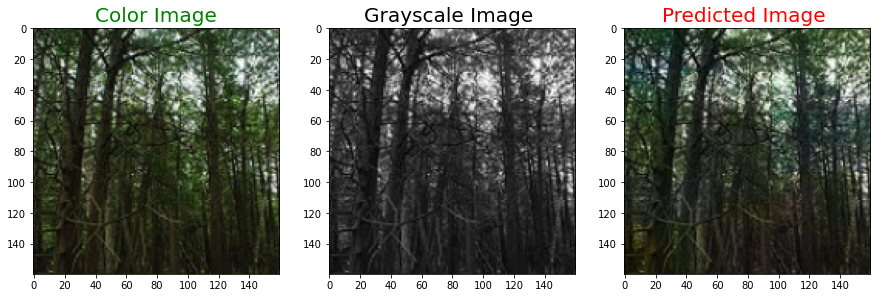

1/1 [==============================] - 0s 40ms/step


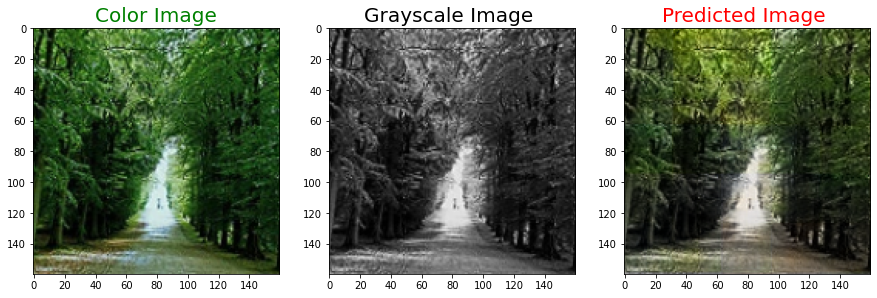

1/1 [==============================] - 0s 41ms/step


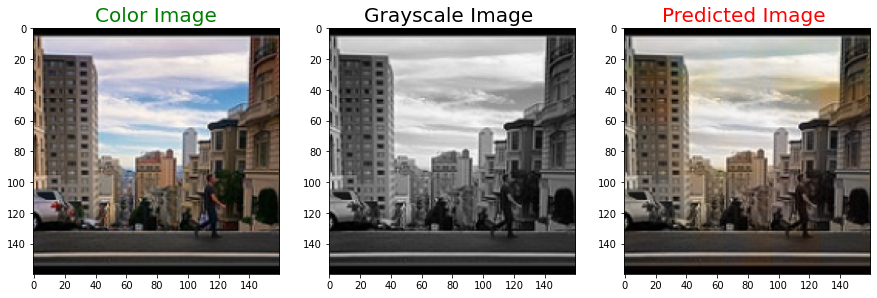

1/1 [==============================] - 0s 31ms/step


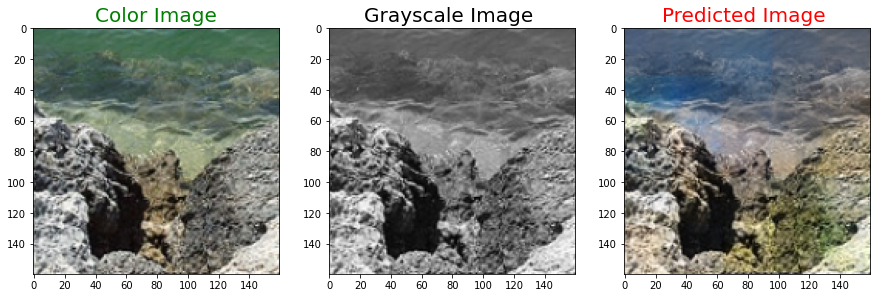

1/1 [==============================] - 0s 42ms/step


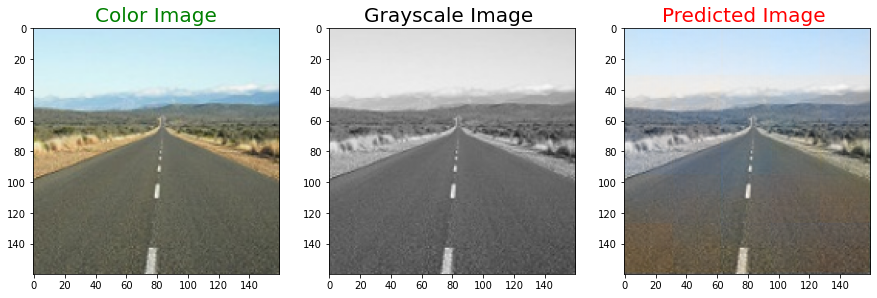

1/1 [==============================] - 0s 29ms/step


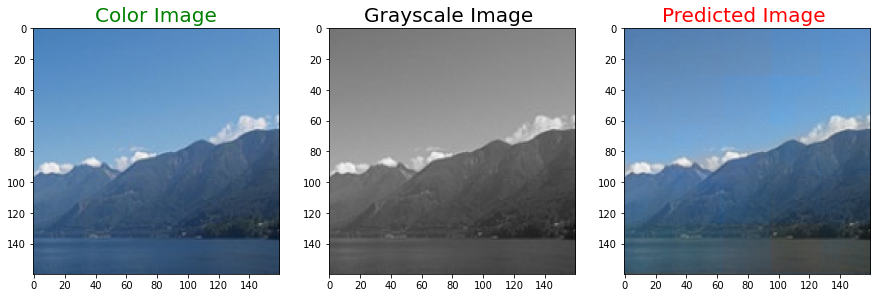

1/1 [==============================] - 0s 38ms/step


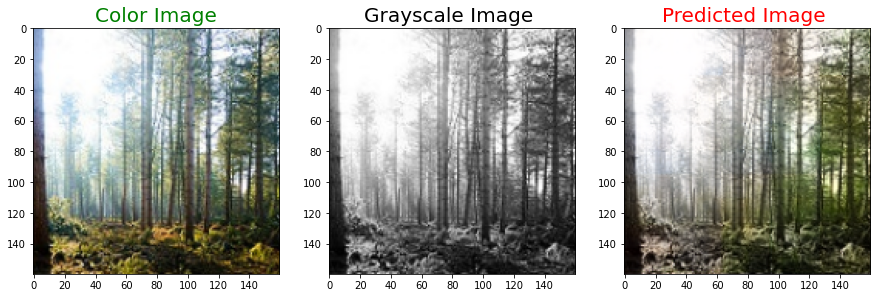

1/1 [==============================] - 0s 40ms/step


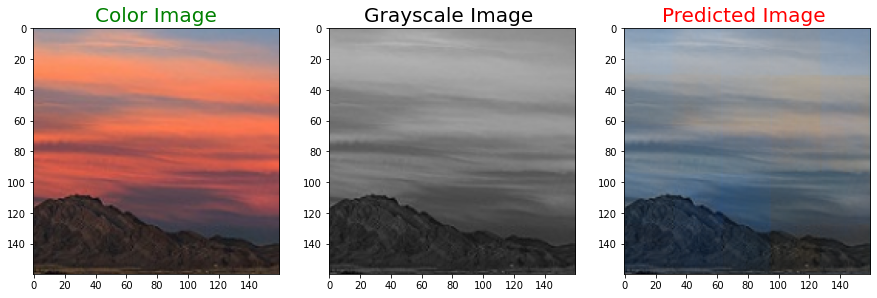

In [14]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

 